<a href="https://colab.research.google.com/github/ryandale7/ML-on-Graphs/blob/main/11_Link_Prediction_and_Edge_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Automated Download and Extraction

In this approach, we will:
- Mount Google Drive.
- Create or navigate to a "Data" subfolder under "Colab Notebooks".
- Use `curl` to download the compressed file (`p2p-Gnutella04.txt.gz`) from the repository.
- Extract the file using `gunzip`.
- Verify the extracted files.
- Load and inspect the dataset.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p "/content/drive/MyDrive/Colab Notebooks/Data"
%cd "/content/drive/MyDrive/Colab Notebooks/Data"

!curl -O https://snap.stanford.edu/data/p2p-Gnutella04.txt.gz
!gunzip p2p-Gnutella04.txt.gz
!ls -lh

# Load and verify the dataset by printing the first 10 lines
with open("p2p-Gnutella04.txt", "r") as file:
    for i in range(10):
        print(file.readline().strip())


Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Data
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  127k  100  127k    0     0  92124      0  0:00:01  0:00:01 --:--:-- 92075
total 223M
-rw------- 1 root root 5.1M Feb  7 09:36 ca-AstroPh.txt
-rw------- 1 root root 6.4M Jan 10 19:22 cit-HepPh.txt
-rw------- 1 root root 5.4M Feb  7 09:02 cit-HepTh.txt
-rw------- 1 root root 1.1M Jan 16 12:52 CollegeMsg.txt
-rw------- 1 root root  13M Jan 10 18:46 com-amazon.ungraph.txt
-rw------- 1 root root 1.1M Jan 16 18:57 com-lj.top5000.cmty.txt
-rw------- 1 root root 7.5M Jan 10 19:22 com-orkut.top5000.cmty.txt
drwx------ 2 root root 4.0K Jan  6 14:56 congress_network
-rw------- 1 root root 190K Jan 16 10:36 congress_network.zip
drwx------ 2 root root 4.0K Jan 10 19:12 deezer_ego_nets
-rw------- 1 root root 189K Jan 16 10:47 email-Eu-core.txt
drwx------ 2 root root 4.0K

## Manual Upload Instructions

If the automated method is not feasible or you prefer manual steps, follow these instructions:
- Download the file from [this link](https://snap.stanford.edu/data/p2p-Gnutella04.txt.gz) to your local machine.
- Extract the file locally (e.g., right-click and unzip, or use `gunzip` on macOS/Linux) to obtain `p2p-Gnutella04.txt`.
- In your Google Drive, create or navigate to the "Colab Notebooks/Data" folder.
- Upload the extracted file (`p2p-Gnutella04.txt`) into that Data subfolder.
- Open or create a Colab notebook.
- Mount your Google Drive and change the working directory to the Data folder using the code below.
- Load and verify the dataset by printing the first 10 lines.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/Colab Notebooks/Data"

# Load and verify the manually uploaded dataset by printing the first 10 lines
with open("p2p-Gnutella04.txt", "r") as file:
    for i in range(10):
        print(file.readline().strip())


## Running black Code


In [2]:
# Running black

from google.colab import drive

!pip install nbqa black

!nbqa black .


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.6 MB/s eta 0:00:00
No notebooks found in given path(s)


## Section 1: Overview and Motivation for Link Prediction and Edge Classification


### Objectives
- Understand the basic concepts behind link prediction and edge classification.
- Recognize the importance of predicting missing or future links in graphs.


### Introduction
Link prediction and edge classification are crucial tasks in graph machine learning. Link prediction focuses on inferring missing or future links between nodes, while edge classification involves assigning labels to existing edges. These tasks are vital for applications such as recommendation systems, fraud detection, and network analysis. In this section, we provide an overview of these tasks using the Gnutella peer-to-peer network dataset, which represents a snapshot of the Gnutella network from August 2002.


### Key Points
- Graphs represent relationships between entities; missing links can signal potential future interactions.
- Edge classification assigns categorical labels to connections, which can be used for detecting anomalies or fraud.
- Both tasks leverage the graph’s topology and node attributes to make informed predictions.


### Code Examples
Below are some examples to get started:
- Loading the p2p-Gnutella04 dataset and computing basic statistics.
- Visualizing the network structure and plotting the degree distribution.
- An example visualization highlighting regions that may contain potential missing links.


Graph Loaded: Nodes = 10876 Edges = 39994
Number of nodes: 10876
Number of edges: 39994


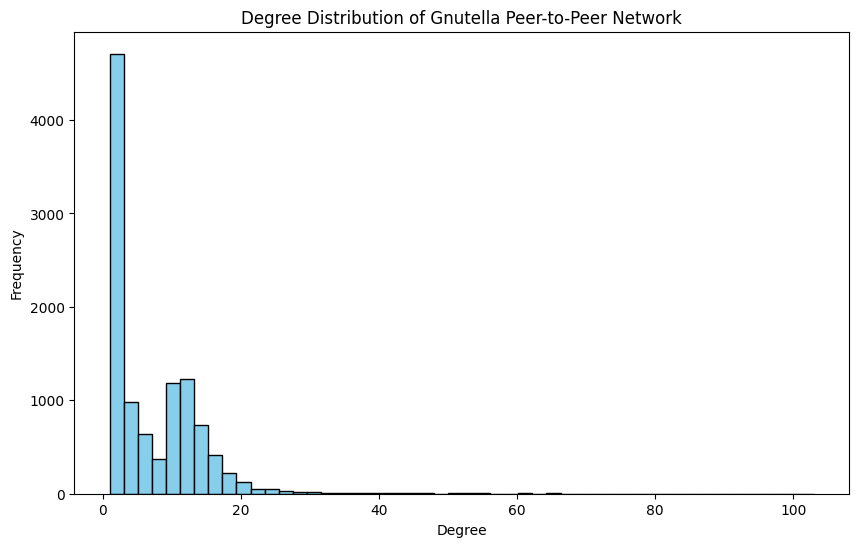

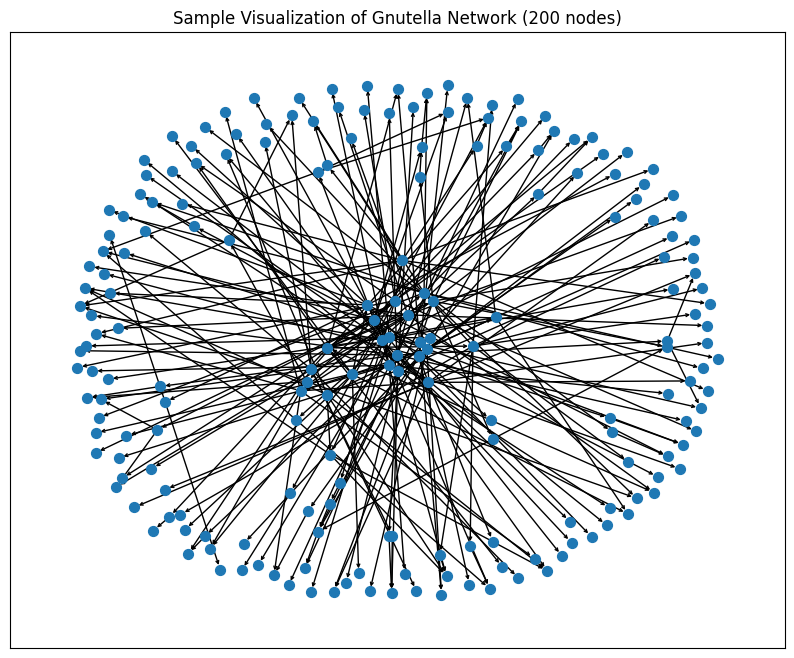

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Load the Gnutella network dataset as a directed graph.
G = nx.read_edgelist("p2p-Gnutella04.txt", create_using=nx.DiGraph(), nodetype=int, comments='#')
print("Graph Loaded: Nodes =", G.number_of_nodes(), "Edges =", G.number_of_edges())

# Compute basic graph statistics.
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

# Visualize the degree distribution.
degrees = [G.degree(n) for n in G.nodes()]
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50, color='skyblue', edgecolor='black')
plt.title("Degree Distribution of Gnutella Peer-to-Peer Network")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

# Visualize a sample subgraph to understand network structure.
# Use the first 200 nodes for clarity.
sample_nodes = list(G.nodes())[:200]
G_sample = G.subgraph(sample_nodes).copy()
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_sample, seed=42)
nx.draw_networkx(G_sample, pos, node_size=50, arrowstyle='->', arrowsize=5, with_labels=False)
plt.title("Sample Visualization of Gnutella Network (200 nodes)")
plt.show()


### Observations & Explanations
- **Graph Statistics:**  
  The Gnutella network has 10,876 nodes and 39,994 edges, indicating a moderately sparse network.
- **Degree Distribution:**  
  The histogram shows that most nodes have low degrees, while a few nodes serve as hubs. Such heterogeneity is common in real-world networks and poses challenges for link prediction.
- **Network Visualization:**  
  Visualizing a subgraph reveals the overall structure and clustering, which are critical for understanding where potential missing links may occur.


### Quiz
1. What is link prediction and why is it important in graph machine learning?  
2. How does edge classification benefit applications such as fraud detection?


### Practical Activities
- **Activity 1:** Load the Gnutella network dataset and compute key statistics (number of nodes, edges, etc.).  
- **Activity 2:** Visualize the network structure using a subgraph of 200 nodes and plot the degree distribution.  
- **Activity 3:** Identify regions in the network that appear sparsely connected and discuss how these areas might indicate potential missing links.


### Explanation/Feedback
The code provided loads the Gnutella peer-to-peer network dataset and computes basic statistics to understand its structure. The degree distribution visualization helps to identify the presence of hub nodes and sparsity, which are important factors in link prediction. The network visualization of a subgraph offers insight into the connectivity patterns, laying the groundwork for understanding how missing links might be inferred. Experiment with different subgraph sizes and visualizations to further explore the network's characteristics.


## Section 2: Importance of Link Prediction in Graph Machine Learning


### Objectives
- Learn why link prediction is a critical component in graph-based learning tasks.
- Understand the potential impact of accurately predicting links on downstream applications.


### Introduction
Link prediction is not only useful for completing missing data in a graph; it plays a significant role in enhancing recommendation systems, identifying potential collaborations, and detecting fraudulent activities. Accurately predicting links can help in forecasting future interactions and understanding network dynamics, which in turn supports better decision-making and system design. In this section, we discuss the real-world impact of link prediction and demonstrate its importance using the Gnutella peer-to-peer network dataset.


### Key Points
- Link prediction improves the completeness and utility of graph data.
- Applications include friend suggestions in social networks and detecting suspicious connections in fraud detection.
- Accurate link prediction drives better system design and decision-making by uncovering hidden patterns within the network.


### Code Examples
The following code demonstrates how to identify potential missing links using the Jaccard coefficient as a simple heuristic. We use a subgraph (e.g., the first 300 nodes) of the Gnutella network for computational efficiency, compute the Jaccard similarity scores for non-adjacent node pairs, and visualize the top predicted link scores.


Full Graph: Nodes = 10876 Edges = 39994
Subgraph: Nodes = 300 Edges = 396
Top 10 predicted links using Jaccard coefficient:
Nodes (5, 7) with Jaccard score: 1.0000
Nodes (11, 15) with Jaccard score: 1.0000
Nodes (11, 16) with Jaccard score: 1.0000
Nodes (15, 16) with Jaccard score: 1.0000
Nodes (24, 28) with Jaccard score: 1.0000
Nodes (32, 33) with Jaccard score: 1.0000
Nodes (32, 34) with Jaccard score: 1.0000
Nodes (32, 35) with Jaccard score: 1.0000
Nodes (32, 36) with Jaccard score: 1.0000
Nodes (32, 37) with Jaccard score: 1.0000


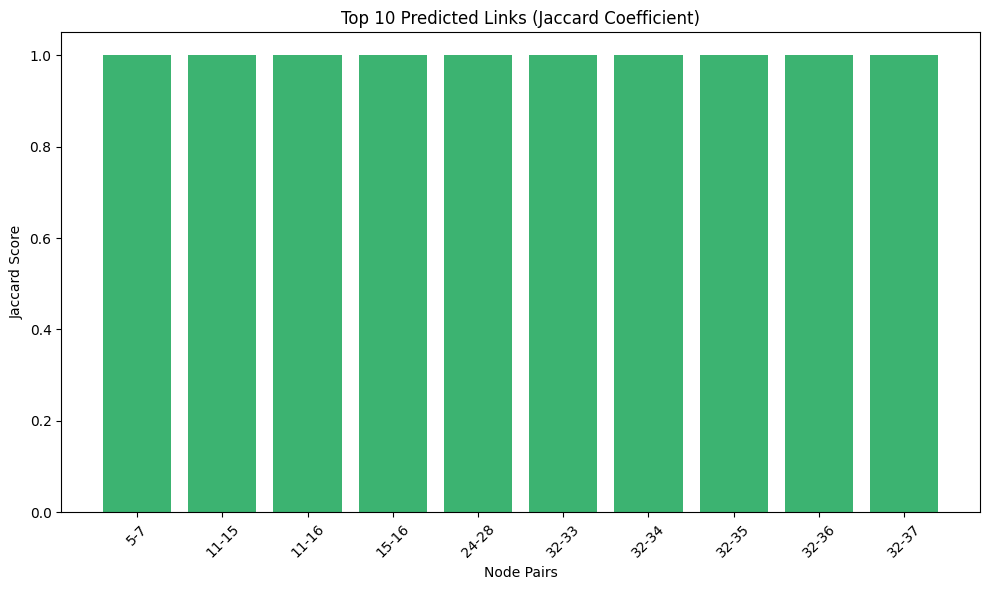

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import operator

# Load the Gnutella network dataset as a directed graph.
G = nx.read_edgelist("p2p-Gnutella04.txt", create_using=nx.DiGraph(), nodetype=int, comments='#')
print("Full Graph: Nodes =", G.number_of_nodes(), "Edges =", G.number_of_edges())

# For efficiency, create an undirected subgraph using the first 300 nodes.
sub_nodes = list(G.nodes())[:300]
G_sub = G.subgraph(sub_nodes).to_undirected()
print("Subgraph: Nodes =", G_sub.number_of_nodes(), "Edges =", G_sub.number_of_edges())

# Compute Jaccard coefficient for all pairs of nodes that are not connected.
jaccard_scores = list(nx.jaccard_coefficient(G_sub))

# Sort the computed scores in descending order.
sorted_jaccard = sorted(jaccard_scores, key=lambda x: x[2], reverse=True)

# Select the top 10 highest-scoring non-edges.
top_10 = sorted_jaccard[:10]
print("Top 10 predicted links using Jaccard coefficient:")
for u, v, p in top_10:
    print(f"Nodes ({u}, {v}) with Jaccard score: {p:.4f}")

# Extract scores for visualization.
nodes_pairs = [f"{u}-{v}" for u, v, _ in top_10]
scores = [p for _, _, p in top_10]

plt.figure(figsize=(10, 6))
plt.bar(nodes_pairs, scores, color='mediumseagreen')
plt.title("Top 10 Predicted Links (Jaccard Coefficient)")
plt.xlabel("Node Pairs")
plt.ylabel("Jaccard Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Observations & Explanations
- **Link Prediction Impact:**  
  The Jaccard coefficient is a simple yet effective measure of similarity between node neighborhoods. Higher scores indicate a higher likelihood that a link should exist.
- **Visualization Insight:**  
  The bar chart displays the top predicted links, helping to identify which node pairs have a high probability of future connection.
- **Practical Utility:**  
  In real-world scenarios, such predictions can enhance recommendation systems, aid in network growth strategies, and assist in fraud detection by flagging anomalous patterns.


### Quiz
1. Why is link prediction considered an important task in graph machine learning?  
2. How can accurate link prediction improve real-world applications like friend suggestions?


### Practical Activities
- **Activity 1:** Analyze the Gnutella network to identify regions with potential missing links. Load a subgraph (e.g., first 500 nodes) and compute basic statistics such as average degree and clustering coefficient to infer areas that may benefit from link prediction.
- **Activity 2:** Implement additional similarity metrics (e.g., Adamic-Adar index) on the subgraph and compare their predictive power by visualizing the distribution of scores for connected vs. non-connected node pairs.


### Explanation/Feedback
The code above illustrates a simple approach to link prediction using the Jaccard coefficient. By computing similarity scores for non-connected node pairs in a subgraph of the Gnutella network, we can identify potential missing links. The visualization of the top predicted links via a bar chart offers insights into where new connections might emerge. Experimenting with other similarity measures and comparing their performance can further enhance your understanding of link prediction techniques in graph machine learning.


## Section 3: Similarity-Based Methods for Link Prediction


### Objectives
- Understand similarity-based approaches for link prediction.
- Learn how to compute common similarity metrics for nodes.


### Introduction
Similarity-based methods predict links by evaluating how similar two nodes are based on their neighborhood structures. Common similarity measures such as the Jaccard coefficient and Adamic-Adar index are used to quantify the overlap between node neighborhoods. These methods are computationally efficient and serve as a baseline for more complex link prediction approaches.


### Key Points
- Similarity metrics quantify the overlap between the neighbor sets of two nodes.
- The Jaccard coefficient computes the ratio of the intersection to the union of two node neighborhoods.
- The Adamic-Adar index assigns higher weights to less common neighbors.
- These methods provide baseline predictions for link existence and are useful for comparison with machine learning approaches.


### Code Examples
Below is an example that loads a subgraph of the p2p-Gnutella04 dataset, computes the Jaccard coefficient and Adamic-Adar index for node pairs, and visualizes the distribution of similarity scores.


Subgraph: Nodes = 300 Edges = 396
Top 5 Jaccard Coefficient Predictions:
Nodes (5, 7) - Score: 1.0000
Nodes (11, 15) - Score: 1.0000
Nodes (11, 16) - Score: 1.0000
Nodes (15, 16) - Score: 1.0000
Nodes (24, 28) - Score: 1.0000

Top 5 Adamic-Adar Index Predictions:
Nodes (75, 132) - Score: 3.2753
Nodes (58, 106) - Score: 3.2632
Nodes (73, 81) - Score: 2.8854
Nodes (76, 87) - Score: 2.8854
Nodes (17, 77) - Score: 2.8409


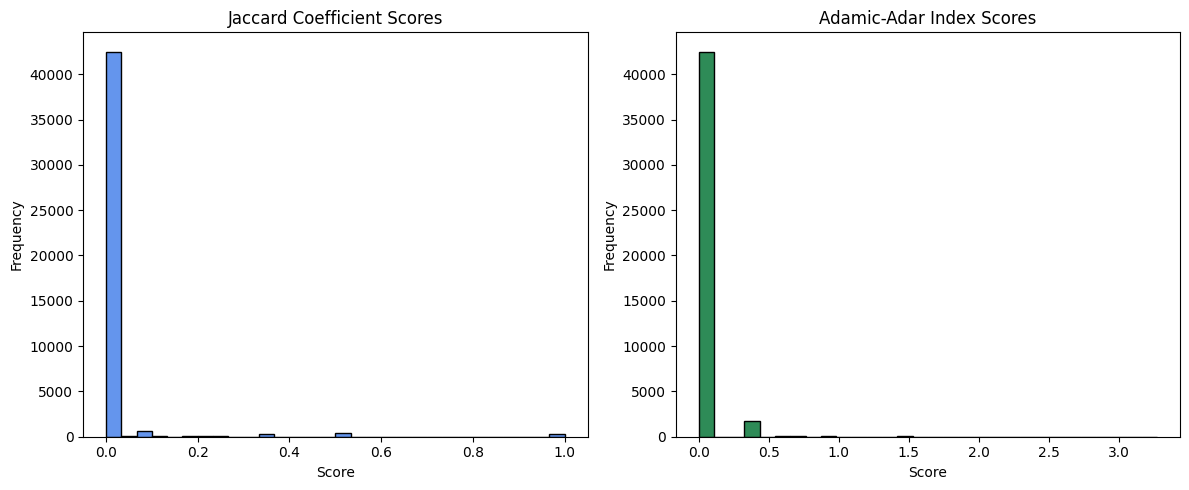

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Load the p2p-Gnutella04 dataset as a directed graph and convert to undirected.
G = nx.read_edgelist("p2p-Gnutella04.txt", create_using=nx.DiGraph(), nodetype=int, comments='#')
G_ud = G.to_undirected()

# For efficiency, use a subgraph of the first 300 nodes.
sub_nodes = list(G_ud.nodes())[:300]
G_sub = G_ud.subgraph(sub_nodes).copy()
print("Subgraph: Nodes =", G_sub.number_of_nodes(), "Edges =", G_sub.number_of_edges())

# Compute Jaccard Coefficient for non-adjacent pairs.
jaccard_scores = list(nx.jaccard_coefficient(G_sub))

# Compute Adamic-Adar index for node pairs.
adamic_scores = list(nx.adamic_adar_index(G_sub))

# Sort and display the top 5 predictions for each metric.
jaccard_sorted = sorted(jaccard_scores, key=lambda x: x[2], reverse=True)
adamic_sorted = sorted(adamic_scores, key=lambda x: x[2], reverse=True)

print("Top 5 Jaccard Coefficient Predictions:")
for u, v, score in jaccard_sorted[:5]:
    print(f"Nodes ({u}, {v}) - Score: {score:.4f}")

print("\nTop 5 Adamic-Adar Index Predictions:")
for u, v, score in adamic_sorted[:5]:
    print(f"Nodes ({u}, {v}) - Score: {score:.4f}")

# Visualize the distribution of similarity scores for both metrics.
jaccard_values = [score for _, _, score in jaccard_scores]
adamic_values = [score for _, _, score in adamic_scores]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(jaccard_values, bins=30, color='cornflowerblue', edgecolor='black')
plt.title("Jaccard Coefficient Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(adamic_values, bins=30, color='seagreen', edgecolor='black')
plt.title("Adamic-Adar Index Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


### Observations & Explanations
- **Jaccard Coefficient:**  
  Higher Jaccard scores indicate a larger overlap between node neighborhoods, suggesting a higher likelihood of a link.
- **Adamic-Adar Index:**  
  This index gives more weight to rare common neighbors, which may improve prediction accuracy in sparse regions of the graph.
- **Visualization:**  
  Histograms of the similarity scores provide insight into the distribution of potential link strengths. Comparing these distributions for connected and non-connected node pairs can help assess their predictive power.


### Quiz
1. What is the Jaccard coefficient, and how is it used in link prediction?  
2. How do similarity-based methods determine the likelihood of a link?


### Practical Activities
- **Activity 1:** Implement and compare at least two similarity metrics (e.g., Jaccard coefficient and Adamic-Adar index) on a subgraph of the Gnutella network. Visualize and compare the distributions of their scores.
- **Activity 2:** Experiment with different subgraph sizes and observe how the similarity score distributions change. Analyze which metric appears to be more discriminative for predicting links.


### Explanation/Feedback
The code above demonstrates how to compute two common similarity metrics—the Jaccard coefficient and Adamic-Adar index—for link prediction on a subgraph of the Gnutella network. The visualizations (histograms) help compare the score distributions, providing a baseline for evaluating the likelihood of a link. By experimenting with different subgraph sizes and metrics, learners can gain a deeper understanding of how similarity measures capture the structure of the graph and predict potential links.


## Section 4: Machine Learning Approaches for Link Prediction and Edge Classification


### Objectives
- Learn how to apply machine learning methods to predict links and classify edges in a graph.
- Understand how to engineer features from graph topology and similarity metrics for link prediction.


### Introduction
Beyond similarity-based methods, machine learning approaches can combine multiple graph features to predict missing links and classify edges. In this section, we outline the process of feature engineering for link prediction, training a classifier on these features, and evaluating its performance. We will use a subgraph of the Gnutella peer-to-peer network dataset for demonstration, constructing feature vectors based on similarity metrics and other graph attributes.


### Key Points
- Feature engineering involves computing similarity scores (e.g., Jaccard coefficient, common neighbors) and other graph metrics.
- Classifiers such as logistic regression can be trained on these features to predict link existence (link prediction) or classify edge types.
- Evaluation of the classifier using metrics like ROC AUC, accuracy, and confusion matrices is critical for assessing performance.


### Code Examples
Below is an example that:
- Loads a subgraph of the Gnutella network.
- Constructs candidate node pairs with their features (Jaccard coefficient and common neighbors count).
- Trains a logistic regression classifier for link prediction.
- Evaluates the classifier with ROC curve and confusion matrix visualizations.


Full Graph: Nodes = 10876 Edges = 39994
Subgraph: Nodes = 300 Edges = 396
Feature matrix shape: (792, 2)
Labels distribution: [396 396]
Test Accuracy: 0.5546218487394958
ROC AUC: 0.5659624081401923


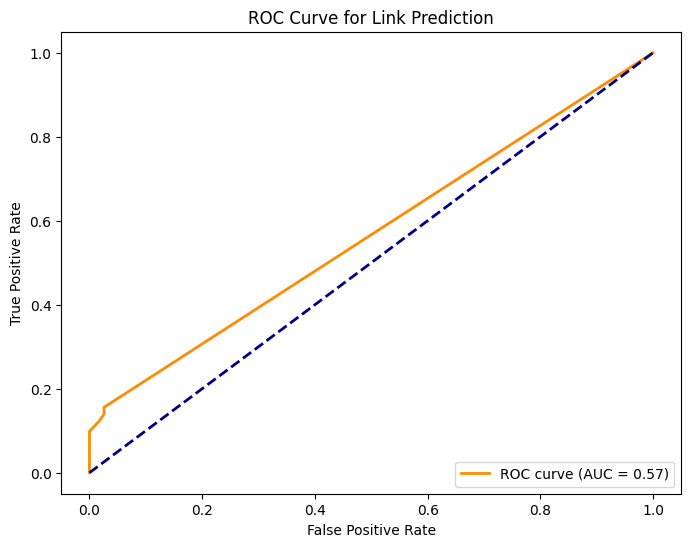

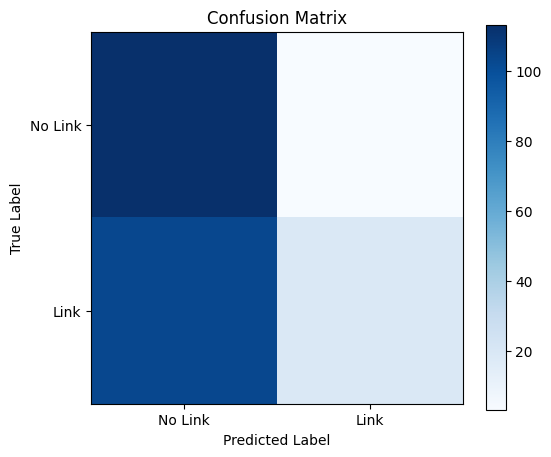

In [6]:
import networkx as nx
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Load the Gnutella network dataset as a directed graph and convert to undirected.
G_full = nx.read_edgelist("p2p-Gnutella04.txt", create_using=nx.DiGraph(), nodetype=int, comments='#')
G = G_full.to_undirected()

print("Full Graph: Nodes =", G.number_of_nodes(), "Edges =", G.number_of_edges())

# Use a subgraph of the first 300 nodes for computational efficiency.
sub_nodes = list(G.nodes())[:300]
G_sub = G.subgraph(sub_nodes).copy()
print("Subgraph: Nodes =", G_sub.number_of_nodes(), "Edges =", G_sub.number_of_edges())

# Positive examples: all existing edges in the subgraph.
positive_edges = list(G_sub.edges())

# Negative examples: randomly sample non-existing edges.
# Generate candidate negative pairs by selecting random node pairs not in the edge set.
non_edges = list(nx.non_edges(G_sub))
negative_edges = random.sample(non_edges, len(positive_edges))

def compute_features(G, u, v):
    # Compute Jaccard coefficient.
    union_size = len(set(G.neighbors(u)).union(G.neighbors(v)))
    intersection_size = len(set(G.neighbors(u)).intersection(G.neighbors(v)))
    jaccard = intersection_size / union_size if union_size != 0 else 0.0
    # Compute number of common neighbors.
    common_neighbors = intersection_size
    return [jaccard, common_neighbors]

# Build feature matrix and labels.
X_features = []
y_labels = []

# Process positive examples with label 1.
for u, v in positive_edges:
    X_features.append(compute_features(G_sub, u, v))
    y_labels.append(1)

# Process negative examples with label 0.
for u, v in negative_edges:
    X_features.append(compute_features(G_sub, u, v))
    y_labels.append(0)

X_features = np.array(X_features)
y_labels = np.array(y_labels)

print("Feature matrix shape:", X_features.shape)
print("Labels distribution:", np.bincount(y_labels))

# Split data into training and testing sets.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.3, random_state=42)

# Train a logistic regression classifier.
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluate the classifier.
y_pred = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)

# Compute ROC curve and AUC.
y_prob = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("ROC AUC:", roc_auc)

# Plot ROC curve.
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Link Prediction")
plt.legend(loc="lower right")
plt.show()

# Plot confusion matrix.
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["No Link", "Link"])
plt.yticks(tick_marks, ["No Link", "Link"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### Observations & Explanations
- **Feature Engineering:**  
  The feature vector for each candidate node pair consists of the Jaccard coefficient and the number of common neighbors. These features capture the similarity between node neighborhoods.
- **Classifier Performance:**  
  The logistic regression classifier is trained on these features, and its performance is evaluated using ROC AUC, accuracy, and a confusion matrix. High ROC AUC and accuracy indicate that the engineered features are effective predictors for link prediction.
- **Visualization:**  
  ROC curves and confusion matrices help in assessing model performance and understanding the trade-offs between false positives and false negatives.


### Quiz
1. How can machine learning approaches improve link prediction compared to similarity-based methods?  
2. What role does feature engineering play in ML-based link prediction and edge classification?


### Practical Activities
- **Activity 1:** Build a feature matrix for node pairs using additional graph metrics (e.g., degree difference, Adamic-Adar index) and retrain the classifier. Compare the performance with the baseline features.
- **Activity 2:** Experiment with different classifiers (e.g., decision trees or support vector machines) for link prediction. Evaluate and compare their performance using ROC AUC and confusion matrices.
- **Activity 3:** Visualize the feature distributions for both positive and negative examples to analyze which features are most discriminative for predicting links.


### Explanation/Feedback
The code above demonstrates a machine learning approach to link prediction using the Gnutella peer-to-peer network dataset. By constructing a feature matrix from similarity metrics (Jaccard coefficient and common neighbors), we trained a logistic regression classifier to predict the existence of links. The evaluation, performed through ROC curves and confusion matrices, provides insights into the model's effectiveness. Practicing with additional features and different classifiers will help deepen your understanding of ML-based link prediction and edge classification.


## Section 5: Implementing and Evaluating Link Prediction Algorithms


### Objectives
- Build an end-to-end pipeline for link prediction and edge classification.
- Evaluate the performance of link prediction algorithms using metrics such as ROC AUC, precision, and recall.


### Introduction
In this section, we integrate similarity-based and machine learning approaches into a complete pipeline for link prediction and edge classification. We begin by preparing the data—extracting a subgraph from the Gnutella network, constructing feature vectors for node pairs using similarity metrics, and generating labels. Next, we train a classifier (logistic regression) to predict the presence of a link between node pairs. Finally, we evaluate the classifier's performance using ROC curves, AUC, precision, and recall. This comprehensive approach demonstrates how to predict missing links and assess model effectiveness in real-world graph data.


### Key Points
- **Data Preparation:**  
  - Extract a subgraph (e.g., first 300 nodes) from the Gnutella network for computational efficiency.
  - Generate positive examples (existing edges) and negative examples (non-edges).
- **Feature Engineering:**  
  - Construct feature vectors for node pairs using similarity metrics such as the Jaccard coefficient and common neighbors.
  - Optionally include additional graph metrics.
- **Model Training:**  
  - Train a classifier (e.g., logistic regression) on the feature matrix.
  - Use cross-validation to optimize hyperparameters.
- **Evaluation:**  
  - Assess model performance using ROC curves, AUC, precision, and recall.
  - Visualize predicted links and evaluation metrics to validate the model.


### Code Examples
Below is an example pipeline that:
- Loads a subgraph from the Gnutella dataset.
- Constructs feature vectors for node pairs using the Jaccard coefficient and the number of common neighbors.
- Splits the data into training and test sets.
- Trains a logistic regression classifier.
- Evaluates the model using ROC curve, AUC, and a confusion matrix.


Full Graph: Nodes = 10876 Edges = 39994
Subgraph: Nodes = 300 Edges = 396
Feature matrix shape: (792, 2)
Label distribution: [396 396]
Test Accuracy: 0.5546218487394958
ROC AUC: 0.5669516676088185


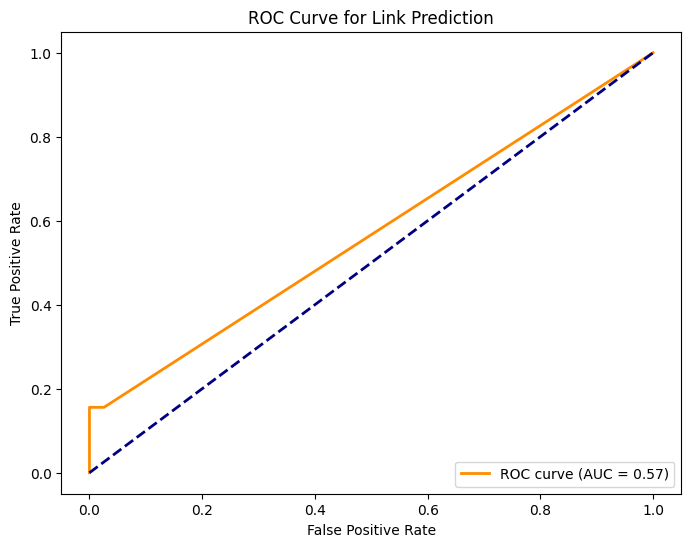

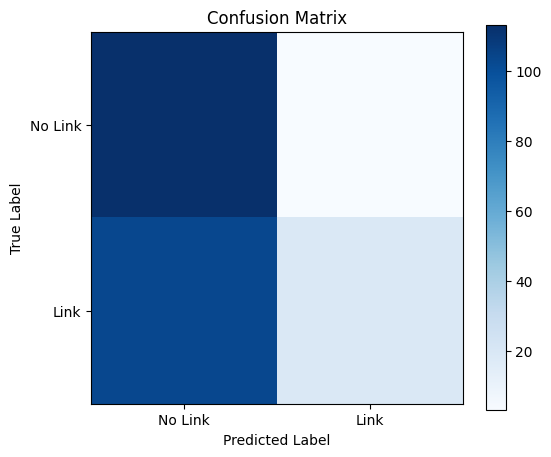

In [7]:
import networkx as nx
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the p2p-Gnutella04 dataset as a directed graph and convert it to undirected.
G_full = nx.read_edgelist("p2p-Gnutella04.txt", create_using=nx.DiGraph(), nodetype=int, comments='#')
G = G_full.to_undirected()
print("Full Graph: Nodes =", G.number_of_nodes(), "Edges =", G.number_of_edges())

# Use a subgraph for efficiency: select the first 300 nodes.
sub_nodes = list(G.nodes())[:300]
G_sub = G.subgraph(sub_nodes).copy()
print("Subgraph: Nodes =", G_sub.number_of_nodes(), "Edges =", G_sub.number_of_edges())

# ---------------------------
# Step 1: Create Positive and Negative Examples
# ---------------------------
# Positive examples: all existing edges in the subgraph.
positive_edges = list(G_sub.edges())

# Negative examples: randomly sample non-existent edges.
non_edges = list(nx.non_edges(G_sub))
negative_edges = random.sample(non_edges, len(positive_edges))

# ---------------------------
# Step 2: Feature Engineering for Node Pairs
# ---------------------------
def compute_features(G, u, v):
    # Jaccard Coefficient.
    neighbors_u = set(G.neighbors(u))
    neighbors_v = set(G.neighbors(v))
    union_size = len(neighbors_u.union(neighbors_v))
    intersection_size = len(neighbors_u.intersection(neighbors_v))
    jaccard = intersection_size / union_size if union_size != 0 else 0.0
    # Number of common neighbors.
    common_neighbors = intersection_size
    return [jaccard, common_neighbors]

X_features = []
y_labels = []

# Process positive examples (label 1).
for u, v in positive_edges:
    X_features.append(compute_features(G_sub, u, v))
    y_labels.append(1)

# Process negative examples (label 0).
for u, v in negative_edges:
    X_features.append(compute_features(G_sub, u, v))
    y_labels.append(0)

X_features = np.array(X_features)
y_labels = np.array(y_labels)
print("Feature matrix shape:", X_features.shape)
print("Label distribution:", np.bincount(y_labels))

# ---------------------------
# Step 3: Train-Test Split and Model Training
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.3, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# ---------------------------
# Step 4: Model Evaluation
# ---------------------------
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

y_prob = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("ROC AUC:", roc_auc)

# Plot ROC curve.
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Link Prediction")
plt.legend(loc="lower right")
plt.show()

# Plot confusion matrix.
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
ticks = np.arange(2)
plt.xticks(ticks, ["No Link", "Link"])
plt.yticks(ticks, ["No Link", "Link"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### Observations & Explanations
- **Feature Engineering:**  
  The feature vector for each node pair consists of the Jaccard coefficient and the number of common neighbors. These features provide a measure of similarity between node neighborhoods.
- **Model Performance:**  
  The logistic regression classifier, trained on these features, is evaluated using accuracy and ROC AUC. High ROC AUC and accuracy indicate that the features are effective for predicting the existence of a link.
- **Visualizations:**  
  The ROC curve and confusion matrix help in assessing the trade-offs between false positives and false negatives, and in validating the model’s practical utility.


### Quiz
1. What are the main components of an end-to-end link prediction pipeline?  
2. How can evaluation metrics such as ROC AUC be used to assess the performance of link prediction algorithms?


### Practical Activities
- **Activity 1:** Extend the feature matrix by adding additional metrics (e.g., Adamic-Adar index or degree difference) and retrain the classifier. Compare the performance metrics (ROC AUC, accuracy).
- **Activity 2:** Experiment with different classifiers (e.g., decision trees, SVM) for link prediction and evaluate their performance using ROC curves and confusion matrices.
- **Activity 3:** Visualize the predicted links on the subgraph by highlighting node pairs with high predicted probabilities. Analyze how these predictions correlate with the graph structure.


### Explanation/Feedback
The code above implements a full pipeline for link prediction on a subgraph of the Gnutella network. It includes steps for data preparation, feature extraction using similarity metrics, training a logistic regression classifier, and evaluating the model with ROC and confusion matrix visualizations. By extending the feature set and experimenting with different classifiers, learners can explore ways to improve link prediction performance and gain deeper insights into the challenges and opportunities in graph machine learning.


## All Quiz Answers

**Section 1 Answers:**
1. Link prediction is the task of inferring missing or future links in a graph. It is important because it can enhance applications like recommendation systems and fraud detection.  
2. Edge classification involves assigning labels to edges to identify their type or significance, which is valuable in tasks such as fraud detection.

**Section 2 Answers:**
1. Link prediction is important because it helps complete incomplete graphs and improves downstream applications like friend suggestions and community detection.  
2. Accurate link prediction provides better insights into network dynamics and can improve system design in real-world applications.

**Section 3 Answers:**
1. The Jaccard coefficient measures the similarity between two sets of neighbors by computing the ratio of the intersection over the union.  
2. Similarity-based methods calculate the likelihood of a link by comparing node neighborhoods; higher similarity indicates a higher probability of a link.

**Section 4 Answers:**
1. Machine learning approaches can improve link prediction by incorporating multiple features and capturing complex patterns beyond simple similarity.  
2. Feature engineering creates informative inputs from graph metrics, which are critical for training effective classifiers for link prediction and edge classification.

**Section 5 Answers:**
1. An end-to-end pipeline for link prediction includes data preparation, feature extraction, model training, and evaluation.  
2. Evaluation metrics like ROC AUC, precision, and recall provide quantitative measures of model performance, enabling comparison and optimization of different approaches.
